In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

try:
    from kaggle_datasets import KaggleDatasets
    dataset_gcs = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
    print('got GCS path via KaggleDatasets .get_gcs_path method')
except ModuleNotFoundError:
    #hardcode path while testing locally
    dataset_gcs = 'gs://'


got GCS path via KaggleDatasets .get_gcs_path method


In [2]:
tf.__version__


'2.2.0'

In [3]:
params = {
    'batch_size' : 128,
    'img_size' : [256, 256],
    'epochs': 350
}


In [4]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
params['batch_size'] = params['batch_size'] * strategy.num_replicas_in_sync

In [6]:
# sub = pd.read_csv(dataset_gcs + '/sample_submission.csv')
# sub.head(1)

In [7]:
train_df = pd.read_csv(dataset_gcs + '/train.csv')
train_df.groupby('target').count() 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
target,,,,,,,
0,32542,32542,32477,32474,32024,32542,32542
1,584,584,584,584,575,584,584


In [8]:
def decode_image_label(tfrec):
    '''
    function to decode an image and target label from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        label: tensor, integer, either 1 or 0
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    label = features['target']
    
    return decoded_image, label
    


In [9]:
def decode_image(tfrec):
    '''
    function to decode an image from tfrecord
    
    args:
        tfrec: tfrecord, single record of training/validation data
    
    returns:
        decoded_image: tensor, converted image from tfrecord
        img_name: tensor, string, Id of the decoded image
    
    '''
    
    features_dictionary = {
        'image': tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
        }
    features = tf.io.parse_single_example(tfrec, features_dictionary)
    decoded_image = tf.io.decode_jpeg(features['image'], 3)
    decoded_image = tf.image.resize(decoded_image, params['img_size'])
    img_name = features['image_name']
    
    return decoded_image, img_name

In [10]:
def normalize_image_label(decoded_image, label):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    to be used when dealing with tfrecords containing labels
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
        label: tensor, target label
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
        label, same as input
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

    return image_tensor, label

In [11]:
def normalize_image(decoded_image):
    '''
    function to convert an image tensor values from 0 to 255 
    -> -1 to 1
    
    args:
        decoded_image: tensor that is an image with values from 0 to 255
    
    returns: 
        image_tensor: tensor that is an image with values from -1 to 1
    
    '''
    
    #add dim at the zero axis Shape will be from (x, y, z) -> (None, x, y, z)
    image_tensor = tf.expand_dims(decoded_image, 0)
    #undo the above line -- this is needed due to TF not allowing a filtered tensor py_function
    image_tensor = tf.gather(image_tensor, 0)

    #convert tensor values to between -1 and 1 (0 to 255 -> -1 to 1)
    image_tensor = (tf.cast(image_tensor, tf.float32) - 127.5) / 127.5

    return image_tensor

In [12]:
def random_flip(image, label):
    '''
    function to randomly flip images on the x and/or y axis
    
    args:
        image: tensor, an image
        label: tensor, target label
    
    returns: 
        image: tensor, same as input, but possibly flipped on x and/or y axis
        label, tensor, same as input
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label  

In [13]:
def get_train_ds(tfrecords, batch_size):
    '''
    function to create a ds pipeline from tfrecord files
    
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    '''
    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
          cache(). #need to remove cache while not usnig TPUs
          map(decode_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          repeat().
          shuffle(512).
          batch(batch_size,
               drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    

    
    return ds
    

In [14]:
def get_test_ds(tfrecords, batch_size):
    '''
    function to create a dataset for test data
    args:
        tfrecords: list, tfrecord file paths
        batch_size: int, batch size for number of records to pass into
            model at a time
    returns:
        ds: tensorflow input pipeline with images and labels
    
    '''

    ds = (tf.data.TFRecordDataset(filenames=[tfrecords],
                                 num_parallel_reads=tf.data.experimental.AUTOTUNE).
#           cache(). #there is no reason to cache this ds -- it is only being read 1x
          map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).
          map(normalize_image_label, num_parallel_calls=tf.data.experimental.AUTOTUNE).
#           map(random_flip).
          batch(batch_size).
#                 drop_remainder=True).
          prefetch(tf.data.experimental.AUTOTUNE)
         )
    
    return ds
    ###come back to this

# model architecture

In [15]:
def set_of_layers(input_layer, 
                  filters_, 
                  kernal, 
                  strides_, 
                  dense=None, 
                  dense_activation=None,
                  dropout=None,
                  cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2D, MaxPooling2D, BatchNormalization, LeadyReLU, Dense,
        Dropout

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2D layer
      kernal: int, kernal size in Conv2D layer
      strides_: int, stride size in MaxPooling2D layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer

    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
    '''
    x = layers.Conv2D(filters_, (kernal, kernal), padding='same')(input_layer)
    x = layers.MaxPooling2D(strides_, strides_)(x)
    x = layers.BatchNormalization()(x)
    if cnn_activation:
        x = cnn_activation(x)
    x = layers.ReLU()(x)
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x)
    if dropout:
        x = layers.Dropout(dropout)(x)


    return x

In [16]:
def deconv_set_of_layers(input_layer, 
                         filters_, 
                         kernal_, 
                         stride, 
                         dense=None, 
                         dense_activation=None, 
                         dropout=None,
                         cnn_activation=None):
    '''
    function to add the following layers to a model:
    Conv2DTranspose, BatchNormalization, LeadyReLU, Dense

    args:
      input_layer : input layer to be fed into above layers
      filters_: int, number of filters in Conv2DTranspose layer
      kernal_: int, kernal size in Conv2DTranspose layer
      strides_: int, stride size in Conv2DTranspose layer
      dense: int, number of units in dense layer, default is None
          Will only add layer if value is passed
      dense_activation: str, activation function to pass into Dense layer
          default is None
      dropout: float, dropout percentage in Dropout layer, default is None
        must be less than 1.0. Will only add layer if value is passed 
      cnn_activation: tensorflow activation layer, default is None
          will only add layer is value is passed. Activation layer will be
          added after the BatchNormalization layer


    returns:
      x: model that is the same as the input_layer input plus above 
        layers added
    '''
    
    x = layers.Conv2DTranspose(filters_,
                              kernal_,
                              (stride, stride),
                              padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    
    if cnn_activation:
        x = cnn_activation(x)
   
    if dense:
        x = layers.Dense(dense, activation=dense_activation)(x)
    
    if dropout:
        x = layers.Dropout(dropout)(x)
    

    return x


In [17]:
def create_model(input_shape=[*params['img_size'], 3], bias_output=None):
    '''
    function to create a model that will be trained on train DS
    
    args:
        input_shape: array, default: [1024, 1024, 3], shape
            of input tensor that will be fed into model
    
    returns:
        model: tf.sequential() model
    '''

    relu = layers.ReLU()
    leakyrelu = layers.LeakyReLU()
    input_tensor = layers.Input(shape=input_shape, name='images_input')
    x = input_tensor
    filters_list = [64, 128, 256, 512, 1024]
    
    for filter_ in filters_list:
        x1 = set_of_layers(x, filter_, 5, 2, 16,  dropout=0.35, cnn_activation=relu)
        x2 = set_of_layers(x, filter_, 5, 2, 16,  dropout=0.35, cnn_activation=leakyrelu)
#         x3 = set_of_layers(x, filter_, 5, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=relu)
#         x4 = set_of_layers(x, filter_, 5, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=leakyrelu)
        
        x = layers.Concatenate()([x1, x2])
#         x = layers.Dense(filter_, activation='elu')(x) #consider adding dropout
#         x = layers.Dropout(0.35)(x)
    
    
    filters_list = [256, 128, 64]
    
    for filter_ in filters_list:
        x1 = deconv_set_of_layers(x, filter_, 4, 2, 16,  dropout=0.35, cnn_activation=relu)
        x2= deconv_set_of_layers(x, filter_, 4, 2, 16,  dropout=0.35, cnn_activation=leakyrelu)
#         x3 = deconv_set_of_layers(x, filter_, 4, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=relu)
#         x4 = deconv_set_of_layers(x, filter_, 4, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=leakyrelu)
        
        x = layers.Concatenate()([x1, x2])
#         x = layers.Dense(filter_, activation='elu')(x)
#         x = layers.Dropout(0.35)(x)        
    
    filters_list = [64, 128, 256]
    
    for filter_ in filters_list:
        x1 = set_of_layers(x, filter_, 5, 2, 16,  dropout=0.35, cnn_activation=relu)
        x2 = set_of_layers(x, filter_, 5, 2, 16,  dropout=0.35, cnn_activation=leakyrelu)
#         x3 = set_of_layers(x, filter_, 5, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=relu)
#         x4 = set_of_layers(x, filter_, 5, 2, 16, 'sigmoid', dropout=0.35, cnn_activation=leakyrelu)
        
        x = layers.Concatenate()([x1, x2])
#         x = layers.Dense(filter_, activation='elu')(x)
#         x = layers.Dropout(0.35)(x)
    

    #layers.Concatenate


    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
#     model.add(layers.Dense(64))
    
    if bias_output is not None:
        bias_output = tf.keras.initializers.Constant(bias_output)
    output_layer = layers.Dense(1, activation='sigmoid', bias_initializer=bias_output)(x)
    
    model=keras.Model(inputs=[input_tensor],
                     outputs=[output_layer])

 
           
    metrics = [
          keras.metrics.TruePositives(name='tp'),
#           keras.metrics.FalsePositives(name='fp'),
#           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
#           keras.metrics.Precision(name='precision'),
#           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = None
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics
)
    

    
    return model



In [18]:
def get_ds_size(files):
    '''
    function to get size of tfrecord Dataset, based on file name
    
    the file name has the number of records in the file, for example:
    train09-2071.tfrec has 2017 records
    
    args:
        files: list of str file names, each item should be the path to a tfrecord file
    
    returns:
        size: int, size of dataset
    '''
    size = 0
    for file in files:
        file_size = int(file.split('.tfrec')[0].split('tfrecords/')[1].split('-')[1])
        size += file_size
    return size

In [19]:
#get test file paths
test_files = tf.io.gfile.glob(dataset_gcs + '/tfrecords/test*.tfrec')

#get train and validation file paths
train_files, valid_files = train_test_split(tf.io.gfile.glob(dataset_gcs + '/tfrecords/train*.tfrec'),
                              test_size=.1, random_state=1)

#create datasets
train_ds = get_train_ds(train_files, params['batch_size'])
valid_ds = get_train_ds(valid_files, params['batch_size'])
test_ds = get_test_ds(test_files, params['batch_size'])

In [20]:
train_size, valid_size = get_ds_size(train_files), get_ds_size(valid_files)
test_size = get_ds_size(test_files)
print('the dataset consists of: {} training images, {} validation images, and {} test images'.
     format(train_size, valid_size, test_size))

the dataset consists of: 28984 training images, 4142 validation images, and 10982 test images


In [21]:
epoch_steps = train_size / params['batch_size'] 
valid_steps = valid_size / params['batch_size']
test_steps = 1.0 * test_size / params['batch_size'] 

In [22]:
#calculate class weights

targets = train_df.groupby('target').count()['diagnosis'].to_list()
target_0 = targets[0]
target_1 = targets[1]
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}

initial_bias = np.log([target_1 / target_0])



In [23]:
with strategy.scope():
    model = create_model(bias_output=initial_bias)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images_input (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 4864        images_input[0][0]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 4864        images_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

# Training

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=50,
                                mode='max',
                                restore_best_weights=True)


history = model.fit(
    train_ds,
#     batch_size=params['batch_size'],
    epochs= params['epochs'], 
    steps_per_epoch=epoch_steps,
    validation_data=valid_ds,
    validation_steps=valid_steps,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/350
29/28 [==============================] - 35s 1s/step - loss: 1.3709 - accuracy: 0.6876 - tp: 214.0000 - auc: 0.5441 - fn: 310.0000 - val_loss: 0.1093 - val_accuracy: 0.9830 - val_tp: 0.0000e+00 - val_auc: 0.5000 - val_fn: 87.0000
Epoch 2/350
29/28 [==============================] - 23s 780ms/step - loss: 0.9182 - accuracy: 0.6615 - tp: 225.0000 - auc: 0.5514 - fn: 299.0000 - val_loss: 0.1188 - val_accuracy: 0.9834 - val_tp: 0.0000e+00 - val_auc: 0.5000 - val_fn: 85.0000
Epoch 3/350
29/28 [==============================] - 22s 769ms/step - loss: 0.8452 - accuracy: 0.7140 - tp: 237.0000 - auc: 0.5921 - fn: 295.0000 - val_loss: 0.1377 - val_accuracy: 0.9836 - val_tp: 0.0000e+00 - val_auc: 0.5000 - val_fn: 84.0000
Epoch 4/350
29/28 [==============================] - 23s 784ms/step - loss: 0.9484 - accuracy: 0.6926 - tp: 263.0000 - auc: 0.6199 - fn: 265.0000 - val_loss: 0.1433 - val_accuracy: 0.9834 - val_tp: 0.0000e+00 - val_auc: 0.4985 - val_fn: 85.0000
Epoch 5/350
29/28 [====

In [25]:
predictions = model.predict(test_ds.map(lambda img, igs: img), steps=test_steps)  

In [26]:
prediction_ids = next(iter(test_ds.
                          map(lambda img, ids:ids).
                          unbatch().
                          batch(test_size))).numpy().astype('str')

Cause: could not parse the source code:

                          map(lambda img, ids:ids).

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
prediction_dict = {
    'image_name': prediction_ids,
    'target': np.concatenate(predictions)
}
submission_ds = pd.DataFrame(prediction_dict)

In [28]:
submission_ds.head()

,image_name,target
0,ISIC_6381819,0.050337
1,ISIC_5583376,0.434673
2,ISIC_6408546,0.000071
3,ISIC_6932354,0.945061
4,ISIC_8191278,0.003169


In [29]:
submission_ds.to_csv('submission.csv', index=False)

# Metrics

In [30]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

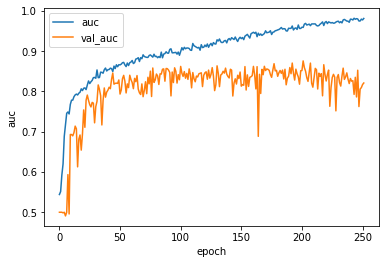

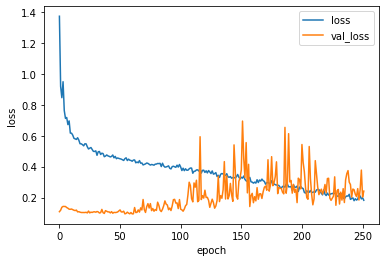

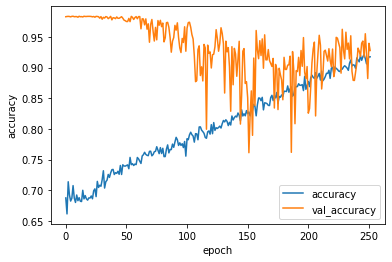

In [31]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [32]:
history.history

{'loss': [1.3709207773208618,
  0.9181996583938599,
  0.8451749682426453,
  0.9483582973480225,
  0.7620341777801514,
  0.7111567258834839,
  0.717616856098175,
  0.6714364886283875,
  0.6953167915344238,
  0.6167508959770203,
  0.6161810159683228,
  0.6033344864845276,
  0.5828312039375305,
  0.5789617300033569,
  0.5757079720497131,
  0.5867489576339722,
  0.5714876651763916,
  0.5479499101638794,
  0.5473689436912537,
  0.5422126650810242,
  0.5344599485397339,
  0.5476610064506531,
  0.5470278263092041,
  0.528260350227356,
  0.5141686201095581,
  0.519288182258606,
  0.52347332239151,
  0.5114681124687195,
  0.4987756013870239,
  0.4980456531047821,
  0.5020077228546143,
  0.47320491075515747,
  0.4961674213409424,
  0.4977782368659973,
  0.47850942611694336,
  0.48685789108276367,
  0.48438286781311035,
  0.4643111824989319,
  0.46827957034111023,
  0.4756180942058563,
  0.46976301074028015,
  0.4666987955570221,
  0.46271008253097534,
  0.4662439525127411,
  0.4753030240535736,


In [33]:
model.save('model.h5')